## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = "resource/non-seasonal/df.csv"
SCALABILITY_FILE = "resource/non-seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/non-seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
train_df = df[:-28]
test_df = df[-28:]
df.head(5)

,date,sales,promo,radio,search,social,tv
0,2019-01-01,888.00000,2003.00000,4779.00000,4603.00000,2123.00000,14120.00000
1,2019-01-02,978.00000,2210.00000,2676.00000,4028.00000,0.00000,7076.00000
2,2019-01-03,902.00000,0.00000,7219.00000,4037.00000,4000.00000,4118.00000
3,2019-01-04,904.00000,0.00000,7826.00000,3722.00000,0.00000,2926.00000
4,2019-01-05,972.00000,1076.00000,7877.00000,4353.00000,1771.00000,10259.00000


In [5]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,promo,3.00000
1,radio,1.25000
2,search,0.80000
3,social,1.30000
4,tv,1.50000


Note that `adstock_df` is optional. If users choose to provide one, make sure the index is named as `regressor`.

In [6]:
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")
adstock_df

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27
regressor,,,,,,,,,,,,,,,,,,,,,
promo,0.08795,0.14952,0.25418,0.25418,0.12709,0.06354,0.03177,0.01589,0.00794,0.00397,...,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
radio,0.00294,0.00529,0.00952,0.01713,0.03084,0.05551,0.09992,0.17985,0.17985,0.12589,...,0.00508,0.00356,0.00249,0.00174,0.00122,0.00085,0.00060,0.00042,0.00029,0.00021
search,0.12903,0.22581,0.22581,0.14678,0.09540,0.06201,0.04031,0.02620,0.01703,0.01107,...,0.00023,0.00015,0.00010,0.00006,0.00004,0.00003,0.00002,0.00001,0.00001,0.00000
social,0.03327,0.04990,0.07486,0.11228,0.16843,0.16843,0.11790,0.08253,0.05777,0.04044,...,0.00163,0.00114,0.00080,0.00056,0.00039,0.00027,0.00019,0.00013,0.00009,0.00007
tv,0.00281,0.00422,0.00632,0.00948,0.01423,0.02134,0.03201,0.04801,0.07202,0.10803,...,0.02944,0.02502,0.02127,0.01808,0.01537,0.01306,0.01110,0.00944,0.00802,0.00682


### Fitting a Basic MMM

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

2023-02-24 18:22:37 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.01,
}
mmm.set_hyper_params(best_params)

2023-02-24 18:22:37 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-24 18:22:37 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-24 18:22:37 - karpiu-mmm - INFO - Best params level_sm_input set as 0.01000


Fit the model with supplied dataframe.

In [9]:
mmm.fit(train_df, num_warmup=1000, num_sample=1000)

2023-02-24 18:22:37 - karpiu-mmm - INFO - Fit final model.
2023-02-24 18:22:37 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-24 18:22:37 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-24 18:22:37 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-24 18:22:37 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

2023-02-24 18:23:25 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.6479636) is within common range (0, 0.8].


### Extracting Insights from the Model

### Attribution

In [11]:
from karpiu.explainability import Attributor

In [13]:
ATTR_START = "2019-03-01"
ATTR_END = "2019-03-01"
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

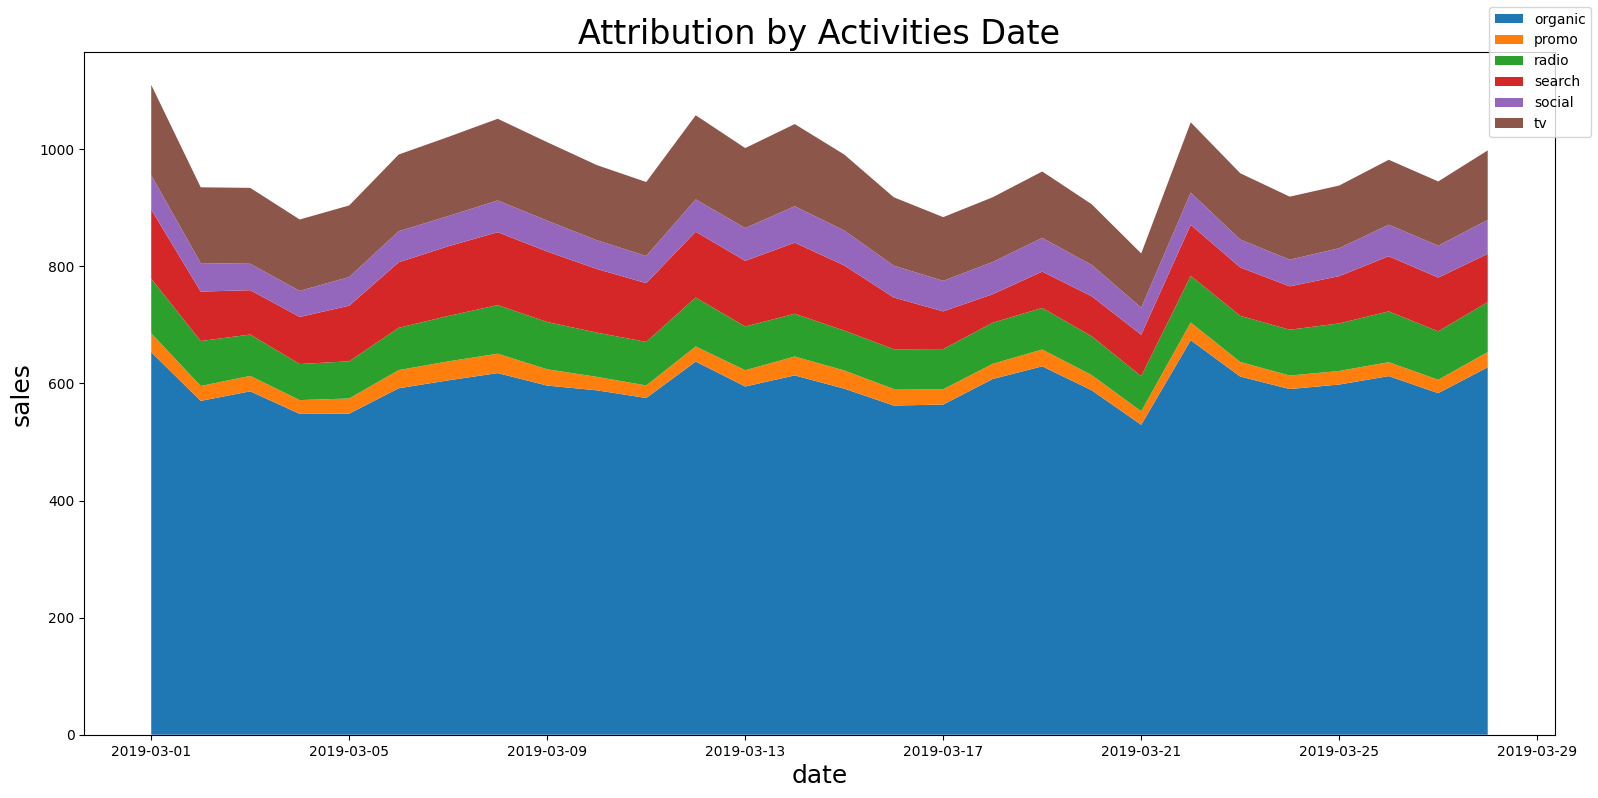

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[["organic"] + paid_channels].values.transpose(),
    labels=["organic"] + paid_channels,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout();

### Cost and Efficiency Analysis

In [15]:
from karpiu.planning import CostCurves

In [16]:
cc = CostCurves(
    model=mmm,
    curve_type="individual",
    n_steps=50,
    channels=paid_channels,
    spend_start=ATTR_START,
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

To prevent overflow, users can provide a scaler in plotting the cost curves.

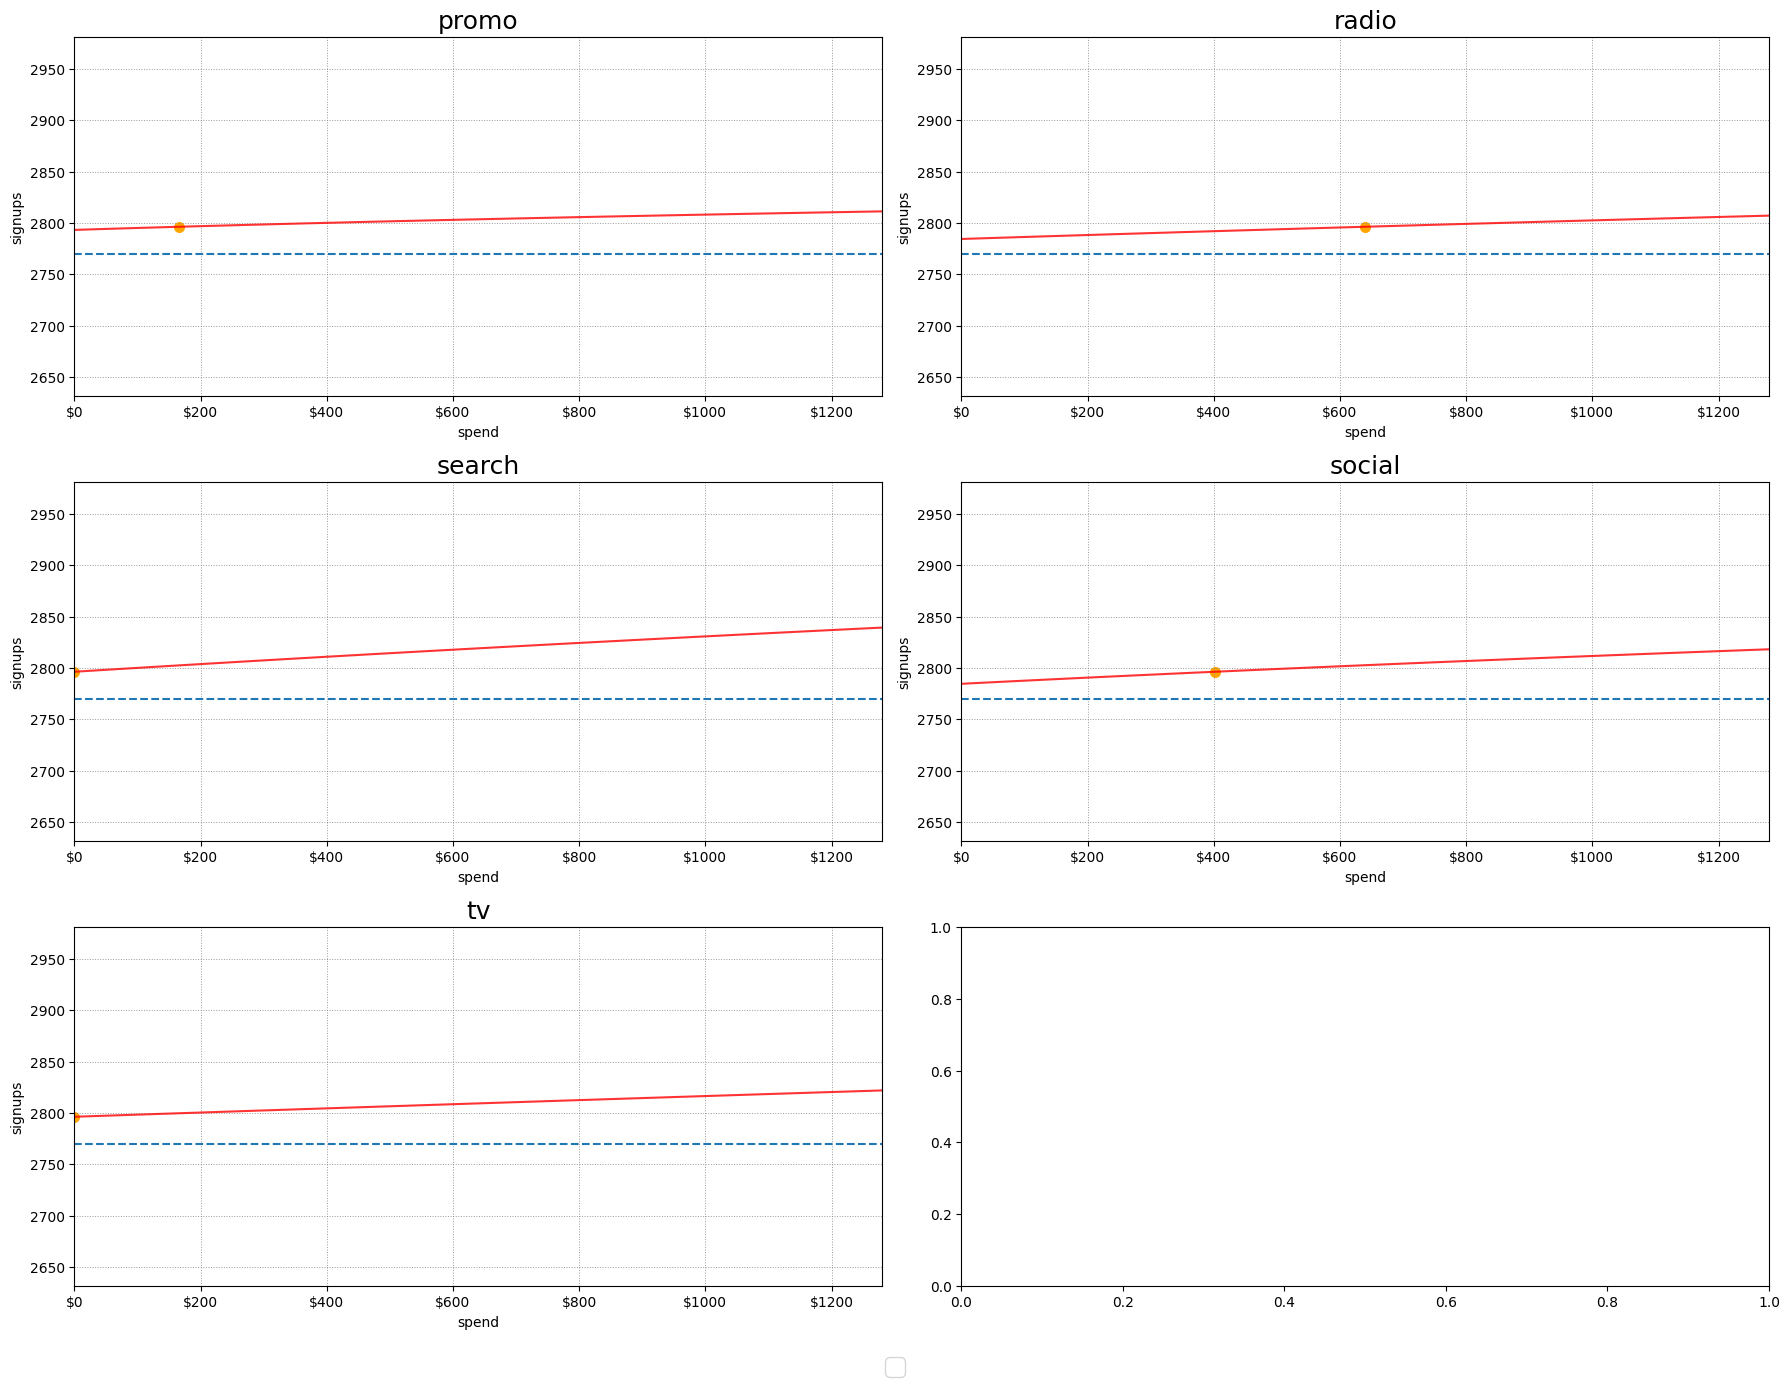

In [17]:
cc.plot(spend_scaler=10, outcome_scaler=10);

### Model Regression Coefficents

In [18]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.04766,0.02871,0.06594,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.10855,0.09161,0.12565,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20670,0.18184,0.23232,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.09562,0.07110,0.12149,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.18943,0.16365,0.21638,1.00000,0.00000,0.00000,0.10000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version.

In [19]:
from orbit.diagnostics.plot import plot_predicted_data

In [20]:
pred_df = mmm.predict(df)

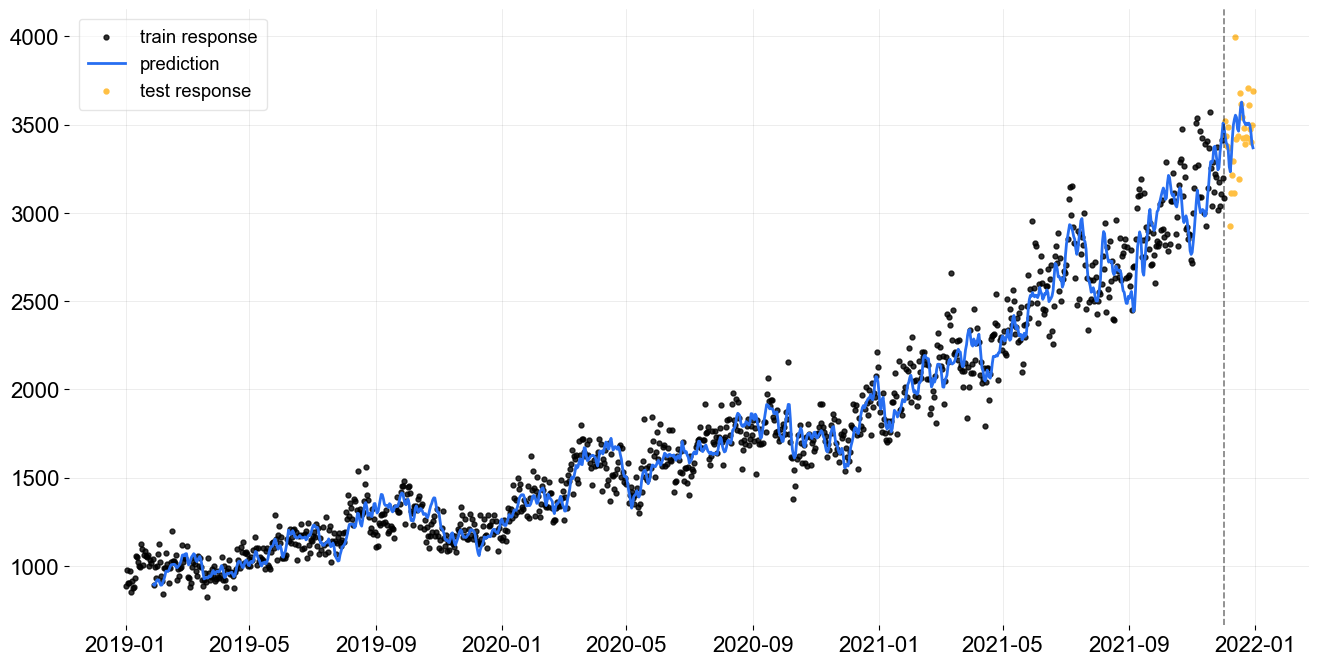

In [21]:
plot_predicted_data(
    training_actual_df=train_df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
    test_actual_df=test_df,
);

Note that this is a non-seasonal model. To model seasonalities and events, check subsequent section.

## Dump Model for Future Usage

In [22]:
import pickle

with open("./resource/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
from karpiu.explainability import FastAttributor
import numpy as np

In [29]:
fa = FastAttributor(
    model=mmm, target_regressors=paid_channels, start=ATTR_START, end=ATTR_END
)

In [30]:
res = fa.make_attribution()

In [31]:
res.shape

(6, 28)

In [32]:
np.sum(res, -1)

array([26625.78803273,    46.42355915,   192.30591748,     0.        ,
         182.48249064,     0.        ])

In [33]:
t_res = np.sum(res, 0)

In [34]:
t_res

array([1110.,  935.,  934.,  880.,  904.,  991., 1021., 1052., 1012.,
        973.,  944., 1058., 1002., 1043.,  991.,  918.,  884.,  918.,
        962.,  906.,  822., 1046.,  959.,  919.,  938.,  982.,  945.,
        998.])

In [35]:
np.sum(activities_attr_df.loc[:, ["organic"] + paid_channels].values, -1)

array([1110.,  935.,  934.,  880.,  904.,  991., 1021., 1052., 1012.,
        973.,  944., 1058., 1002., 1043.,  991.,  918.,  884.,  918.,
        962.,  906.,  822., 1046.,  959.,  919.,  938.,  982.,  945.,
        998.])

In [37]:
np.sum(activities_attr_df.loc[:, ["organic"] + paid_channels].values, 0)

array([16696.10323469,   750.82978431,  2105.450199  ,  2591.67986372,
        1467.64313314,  3435.29378513])

In [38]:
np.sum(spend_attr_df.loc[:, ["organic"] + paid_channels].values, 0)

array([653.45486766,  29.38498435, 119.0600089 ,   0.        ,
       114.30103896,   0.        ])

In [125]:
spend_attr_df.loc[30]

date       2019-03-31 00:00:00
organic              595.81538
promo                  0.00000
radio                  0.00000
search               118.43703
social                60.90998
tv                   160.36585
Name: 30, dtype: object

In [104]:
res[4]

array([  0.        ,   0.51653546,   1.283935  ,   2.49667806,
         4.3374055 ,   7.19152207,  11.24739803,  17.19417319,
        26.42458653,  40.21574085,  61.16149341,  82.09453541,
        98.13310561, 107.86122935, 111.42058061, 111.22745031,
       107.22079068, 105.83034272, 110.51188856, 111.46351098,
       114.39248554, 122.08824039, 132.53037348, 131.32487702,
       129.15104141, 133.35669391, 142.54090843, 147.01392002,
       151.7770099 , 155.72350044, 150.6182803 , 143.76951297,
       144.03910848, 147.63043284, 147.94548099, 148.62348001,
       142.55742521, 132.60911892, 128.17691876, 118.33234533,
        97.22331251,  77.91559089,  64.9277623 ,  54.98011989,
        48.03064863,  39.88312156,  32.04288937,  25.22335194,
        19.58086191,  16.32897837,  13.74757013,  10.79394292,
         8.39641482,   7.26365445,   4.98982782,   3.370952  ,
         2.63264085,   0.94281087])

In [102]:
activities_attr_df

,date,organic,promo,radio,search,social,tv
0,2019-03-01,654.33329,31.35550,93.59483,118.22183,58.15532,154.33922
1,2019-03-02,570.91299,24.70885,77.12819,84.48038,48.24194,129.52766
2,2019-03-03,587.24685,25.70627,70.90871,75.72791,44.78998,129.62028
3,2019-03-04,548.67808,22.95712,61.83437,80.41288,44.18650,121.93105
4,2019-03-05,549.29215,25.14168,63.81349,94.88958,48.64021,122.22289
...,...,...,...,...,...,...,...
53,2019-04-23,648.86250,34.50491,84.89367,131.75116,59.01560,147.97215
54,2019-04-24,644.31893,30.94156,90.63140,109.82556,60.07202,142.21053
55,2019-04-25,687.48273,30.02753,97.72173,102.90629,66.73523,153.12648
56,2019-04-26,608.37519,25.33903,85.27818,97.20437,60.76799,142.03524


In [58]:
spend_attr_df.loc[:, paid_channels].sum()

promo     763.63308
radio    2222.63444
search   2773.30785
social   1761.50104
tv       3599.83299
dtype: float64

In [74]:
fa.target_regressor_matrix[0]

array([1664., 6400.,    0., 4016.,    0.])

In [90]:
res[4]

array([  0.        ,  17.03826946,  11.56561089,   9.97396833,
        11.16678539,  14.65895569,  20.25781337,  27.08608681,
        37.45123216,  53.45313717,  74.63274468,  91.85120821,
       102.75545643, 107.49520262, 108.18727411, 106.50063793,
       102.43551559, 100.94566072, 102.16438593, 100.97750623,
       101.90288371, 107.2087101 , 114.30044567, 113.07908024,
       110.39883481, 112.07983625, 118.66507749, 122.55654946,
       126.42039435, 129.01315512, 124.60388843, 129.16882888,
       146.78628002, 173.34752934, 196.42573017, 216.97224908,
       224.84411507, 233.5646805 , 268.19756915, 302.71923537,
       316.23398645, 325.00194392, 339.22649894, 348.38393471,
       358.07662697, 350.72516349, 344.2815508 , 355.68822502,
       380.3698456 , 415.28326575, 436.12871927, 443.78161639,
       442.62934503, 435.36432806, 418.72463178, 415.95487547,
       432.19177195, 452.66911102])

In [67]:
fa.pred_zero

array([599.60754528, 601.63232325, 602.24584961, 602.76460658,
       602.19697934, 601.13146237, 600.43920754, 599.84122788,
       599.35477405, 598.28803388, 596.97393352, 595.6316565 ,
       594.93895283, 593.63983673, 592.57328315, 591.27161661,
       589.36636372, 587.34518712, 585.5756907 , 584.5826653 ,
       583.23226311, 580.88543412, 580.64615861, 579.96606894,
       578.86590317, 577.82519954, 577.07194686, 576.07303527,
       575.71874413, 574.94771142, 573.86171347, 573.16268821,
       572.2152032 , 571.05792537, 569.97995868, 569.75090127,
       568.59937499, 568.257238  , 567.63422999, 566.56380256,
       565.92377727, 565.67230833, 566.00926651, 565.83414204,
       565.90281018, 565.82871006, 565.69284261, 565.10446056,
       565.01371207, 565.15744158, 566.05638875, 566.54589942,
       566.84587989, 567.00141539, 568.27252432, 569.46680886,
       571.68309035, 573.27836412])

In [64]:
spend_attr_df

,date,organic,promo,radio,search,social,tv
0,2019-03-01,654.33329,28.62111,119.57675,0.00000,113.43486,0.00000
1,2019-03-02,570.91299,0.00000,112.90661,0.00000,38.33749,211.29609
2,2019-03-03,587.24685,40.06371,0.00000,122.06088,0.00000,225.47826
3,2019-03-04,548.67808,31.84377,149.84317,143.71524,96.73454,229.38838
4,2019-03-05,549.29215,45.94169,107.02828,135.95701,76.61467,125.62857
5,2019-03-06,592.65397,44.39573,19.89434,138.95423,0.00000,108.39611
6,2019-03-07,606.19296,0.00000,32.98895,125.90703,0.00000,111.66160
7,2019-03-08,618.57315,29.49341,0.00000,136.85546,71.06921,0.00000
8,2019-03-09,597.10280,0.00000,135.54997,126.56659,54.94261,82.65704
9,2019-03-10,588.90821,27.97178,108.35145,0.00000,122.93511,149.79377
